In [ ]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 260, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 260 (delta 57), reused 51 (delta 51), pack-reused 171
Receiving objects: 100% (260/260), 53.34 MiB | 13.86 MiB/s, done.
Resolving deltas: 100% (118/118), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=22409 sha256=3d0f8c94858a77060fdf7fd1ba20ebb0784de826f2b730f9dddeebf1453c48e9
  Stored in directory: /tmp/pip-ephem-wheel-cache-076dsb09/wheels/55/59/29/0fb1c635652157734

In [ ]:
from dul_2021.utils.hw7_utils import *

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import numpy as np
import torch
import torch.optim as optim
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from tqdm.auto import trange
from torch.distributions.normal import Normal

# Question 1: GANs on CIFAR-10

In this exercise, you will train GANs on CIFAR-10. Execute the cell below to visualize the dataset. 

Files already downloaded and verified


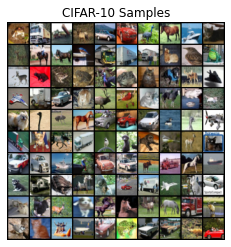

In [ ]:
visualize_q1_data()

 We'll use the CIFAR-10 architecture from the [SN-GAN paper](https://arxiv.org/pdf/1802.05957.pdf), with $z \in \mathbb R ^{128}$, with $z \sim \mathcal N (0, I_{128})$. Instead of upsampling via transposed convolutions and downsampling via pooling or striding, we'll use these DepthToSpace and SpaceToDepth methods for changing the spatial configuration of our hidden states. 

```
class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, d_height, d_width, d_depth) = output.size()
        s_depth = int(d_depth / self.block_size_sq)
        s_width = int(d_width * self.block_size)
        s_height = int(d_height * self.block_size)
        t_1 = output.reshape(batch_size, d_height, d_width, self.block_size_sq, s_depth)
        spl = t_1.split(self.block_size, 3)
        stack = [t_t.reshape(batch_size, d_height, s_width, s_depth) for t_t in spl]
        output = torch.stack(stack, 0).transpose(0, 1).permute(0, 2, 1, 3, 4).reshape(batch_size, s_height, s_width,
                                                                                      s_depth)
        output = output.permute(0, 3, 1, 2)
        return output


class SpaceToDepth(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, s_height, s_width, s_depth) = output.size()
        d_depth = s_depth * self.block_size_sq
        d_width = int(s_width / self.block_size)
        d_height = int(s_height / self.block_size)
        t_1 = output.split(self.block_size, 2)
        stack = [t_t.reshape(batch_size, d_height, d_depth) for t_t in t_1]
        output = torch.stack(stack, 1)
        output = output.permute(0, 2, 1, 3)
        output = output.permute(0, 3, 1, 2)
        return output

# Spatial Upsampling with Nearest Neighbors
Upsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
    x = torch.cat([x, x, x, x], dim=1)
    DepthToSpace(block_size=2)
    Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=padding)


# Spatial Downsampling with Spatial Mean Pooling
Downsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
        SpaceToDepth(2)
        torch.sum(x.chunk(4, dim=1)) / 4.0
        nn.Conv2d(in_dim, out_dim, kernel_size,
                              stride=stride, padding=padding, bias=bias)
```

Here's pseudocode for how we'll implement a ResBlockUp, used in the generator:

```
ResnetBlockUp(x, in_dim, kernel_size=(3, 3), n_filters=256):
    _x = x
    _x = nn.BatchNorm2d(in_dim)(_x)
    _x = nn.ReLU()(_x)
    _x = nn.Conv2d(in_dim, n_filters, kernel_size, padding=1)(_x)
    _x = nn.BatchNorm2d(n_filters)(_x)
    _x = nn.ReLU()(_x)
    residual = Upsample_Conv2d(n_filters, n_filters, kernel_size, padding=1)(_x)
    shortcut = Upsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)(x)
    return residual + shortcut
```
The ResBlockDown module is similar, except it uses Downsample_Conv2d and omits the BatchNorm.

Finally, here's the architecture for the generator:
```
def Generator(*, n_samples=1024, n_filters=128):
    z = Normal(0, 1)([n_samples, 128])
    nn.Linear(128, 4*4*256)
    reshape output of linear layer
    ResnetBlockUp(in_dim=256, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    nn.BatchNorm2d(n_filters),
    nn.ReLU(),
    nn.Conv2d(n_filters, 3, kernel_size=(3, 3), padding=1),
    nn.Tanh()
```
Again, the discriminator has the same architecture, except with ResnetBlockDown and no BatchNorm.

**Hyperparameters**

We'll implement [WGAN-GP](https://arxiv.org/abs/1704.00028), which uses a gradient penalty to regularize the discriminator. Use the Adam optimizer with $\alpha = 2e-4$, $\beta_1 = 0$, $\beta_2 = 0.9$, $\lambda = 10$, $n_{critic} = 5$. Use a batch size of 256 and n_filters=128 within the ResBlocks. Train for at least 25000 gradient steps, with the learning rate linearly annealed to 0 over training. 

**You will provide the following deliverables**
1. Inception score (CIFAR-10 version) of the final model. We provide a utility that will automatically do this for you.
2. Discriminator loss across training
3. 100 samples. 

## Solution

In [ ]:
class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size
 
    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, d_height, d_width, d_depth) = output.size()
        s_depth = int(d_depth / self.block_size_sq)
        s_width = int(d_width * self.block_size)
        s_height = int(d_height * self.block_size)
        t_1 = output.reshape(batch_size, d_height, d_width, self.block_size_sq, s_depth)
        spl = t_1.split(self.block_size, 3)
        stack = [t_t.reshape(batch_size, d_height, s_width, s_depth) for t_t in spl]
        output = torch.stack(stack, 0).transpose(0, 1).permute(0, 2, 1, 3, 4).reshape(batch_size, s_height, s_width,
                                                                                      s_depth)
        output = output.permute(0, 3, 1, 2)
        return output

In [ ]:
class SpaceToDepth(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size
 
    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, s_height, s_width, s_depth) = output.size()
        d_depth = s_depth * self.block_size_sq
        d_width = int(s_width / self.block_size)
        d_height = int(s_height / self.block_size)
        t_1 = output.split(self.block_size, 2)
        stack = [t_t.reshape(batch_size, d_height, d_depth) for t_t in t_1]
        output = torch.stack(stack, 1)
        output = output.permute(0, 2, 1, 3)
        output = output.permute(0, 3, 1, 2)
        return output

In [ ]:
class Upsample_Conv2d(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1, bias=True):
        super().__init__()
        self.conv = nn.Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=padding, bias=bias)
        self.depth2space = DepthToSpace(2)

    def forward(self, x):
        x = torch.cat([x, x, x, x], dim=1)
        x = self.depth2space(x)
        x = self.conv(x)
        return x

class Downsample_Conv2d(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1, bias=True):
        super().__init__()
        self.conv = nn.Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=padding, bias=bias)
        self.space2depth = SpaceToDepth(2)

    def forward(self, x):
        x = self.space2depth(x)
        x = sum(x.chunk(4, dim=1)) / 4.0
        x = self.conv(x)
        return x    

In [ ]:
class ResnetBlockUp(nn.Module):
    def __init__(self, in_dim, kernel_size=(3, 3), n_filters=256):
        super().__init__()
        self.norm1 = nn.BatchNorm2d(in_dim)
        self.conv = nn.Conv2d(in_dim, n_filters, kernel_size, padding=1)
        self.norm2 = nn.BatchNorm2d(n_filters)
        self.relu = nn.ReLU()

        self.upsample1 = Upsample_Conv2d(n_filters, n_filters, kernel_size, padding=1)
        self.upsample2 = Upsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)
    
    def forward(self, x):
        output = self.conv(self.relu(self.norm1(x)))
        output = self.relu(self.norm2(output))
        residual = self.upsample1(output)
        shortcut = self.upsample2(x)
        return residual + shortcut

In [ ]:
class ResnetBlockDown(nn.Module):
    def __init__(self, in_dim, kernel_size=(3, 3), n_filters=256):
        super().__init__()
        self.conv = nn.Conv2d(in_dim, n_filters, kernel_size, padding=1)
        self.relu = nn.ReLU()

        self.downsample1 = Downsample_Conv2d(n_filters, n_filters, kernel_size, padding=1)
        self.downsample2 = Downsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)
    
    def forward(self, x):
        output = self.conv(self.relu(x))
        output = self.relu(output)
        residual = self.downsample1(output)
        shortcut = self.downsample2(x)
        return residual + shortcut

In [ ]:
class Generator(nn.Module):
  def __init__(self, n_filters=128):
      super(Generator, self).__init__()
      self.norm = Normal(torch.tensor(0.0).to(device), torch.tensor(1.0).to(device))
      self.linear = nn.Linear(128, 4*4*256)
      self.resnet1 = ResnetBlockUp(in_dim=256, n_filters=n_filters)
      self.resnet2 = ResnetBlockUp(in_dim=n_filters, n_filters=n_filters)
      self.resnet3 = ResnetBlockUp(in_dim=n_filters, n_filters=n_filters)
      self.batch_norm = nn.BatchNorm2d(n_filters)
      self.relu = nn.ReLU()
      self.conv = nn.Conv2d(n_filters, 3, kernel_size=(3, 3), padding=1)
      self.tanh = nn.Tanh()

  
  def forward(self, x):
      output = self.linear(x).reshape(-1, 256, 4, 4)
      output = self.resnet3(self.resnet2(self.resnet1(output)))
      output = self.relu(self.batch_norm(output))
      output = self.tanh(self.conv(output))
      return output
  
  def sample(self, n_samples = 1024):
      z = self.norm.sample([n_samples, 128])
      return self.forward(z)

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, n_filters=128):
      super(Discriminator, self).__init__()    
      self.resnet1 = ResnetBlockDown(in_dim=3, n_filters=n_filters)
      self.resnet2 = ResnetBlockDown(in_dim=n_filters, n_filters=n_filters)
      self.resnet3 = ResnetBlockDown(in_dim=n_filters, n_filters=n_filters)
      self.relu = nn.ReLU()
      self.conv = nn.Conv2d(n_filters, n_filters, kernel_size=(3, 3), padding=1)
      self.linear = nn.Linear(128, 1)
  
  
  def forward(self, x):  
      output = self.resnet3(self.resnet2(self.resnet1(x)))
      output = self.relu(output)
      output = self.conv(output)
      output = output.sum((2, 3))
      output = self.linear(output)
      return output

In [ ]:
def train(generator, discriminator, g_loss, d_loss, train_loader, g_step,
          g_optimizer = None, d_optimizer = None, 
          epoch = 10, n = 5000):

  
    g_losses, d_losses = [], []

    for e in tqdm(range(epoch), leave=True, position=0):      

        generator.train()  
        discriminator.train() 
        g_epoch_losses, d_epoch_losses = [], []

        iter = 0
        for x in train_loader:
            iter += 1
            x = x.to(device).float().contiguous()

            # discriminator      
            d = d_loss(generator, discriminator, x)
            d_optimizer.zero_grad()
            d.backward()
            d_optimizer.step()
            d_epoch_losses.append(d.item())

            # generator
            if iter % g_step == 0:
                g = g_loss(generator, discriminator, x)
                g_optimizer.zero_grad()
                g.backward()
                g_optimizer.step()
                g_epoch_losses.append(g.item())
    
        g_losses.extend(g_epoch_losses)
        d_losses.extend(d_epoch_losses)

    return g_losses, d_losses

In [ ]:
def regularization(generator, discriminator, x, gamma = 10):
    batch_size = x.shape[0]
    fake_x = generator.sample(batch_size)
    eps = torch.rand(batch_size, 1, 1, 1).to(device)
    eps = eps.repeat(1, *x.shape[1:])
    hat_x = eps * x.data + (1 - eps) * fake_x.data
    hat_x.requires_grad = True
    output = discriminator(hat_x)
    gradients = torch.autograd.grad(outputs=output, inputs=hat_x,
                                    grad_outputs=torch.ones(output.size()).to(device),
                                    create_graph=True, retain_graph=True)[0]
    gradients = gradients.reshape(batch_size, -1)
    gradients_norm = torch.norm(gradients, dim = 1)
    return gamma * ((gradients_norm - 1) ** 2).mean()

def g_loss(generator, discriminator, x):
    fake_x = generator.sample(x.shape[0])
    return -discriminator(fake_x).mean()

def d_loss(generator, discriminator, x):
    loss_g = g_loss(generator, discriminator, x)
    reg = regularization(generator, discriminator, x, gamma = 10)
    return -loss_g - discriminator(x).mean() + reg

In [ ]:
def q1(train_data):
    
    """
    train_data: An (n_train, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]

    Returns
    - a (# of training iterations,) numpy array of WGAN critic train losses evaluated every minibatch
    - a (1000, 32, 32, 3) numpy array of samples from your model in [0, 1]. 
        The first 100 will be displayed, and the rest will be used to calculate the Inception score. 
    """

    """ YOUR CODE HERE """

    train_loader = data.DataLoader(train_data, batch_size=256, shuffle=True)

    generator = Generator(128).to(device)
    discriminator = Discriminator(128).to(device)

    g_optimizer = optim.Adam(generator.parameters(), lr=2e-4, betas=(0, 0.9))
    d_optimizer = optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0, 0.9))

    g_losses, d_losses = train(generator, discriminator,
                               g_loss, d_loss, train_loader, g_step = 5,
                               g_optimizer = g_optimizer,
                               d_optimizer = d_optimizer, epoch = 20)

    with torch.no_grad():
        samples = generator.sample(1000)
        samples = samples.permute(0, 2, 3, 1).detach().cpu().numpy()

    return d_losses, np.clip(samples, 0, 1)    

## Results

Files already downloaded and verified


100%|██████████| 10/10 [1:38:28<00:00, 590.88s/it]


..........Inception score: 4.5262914


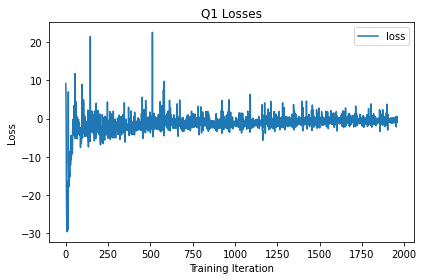

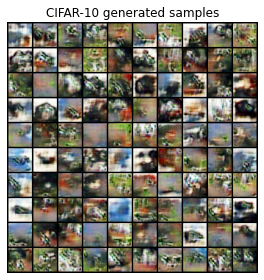

In [ ]:
q1_save_results(q1)

# Question 2: Representation Learning with BiGAN on MNIST

In this part, we train a BiGAN on the MNIST dataset. Execute the cell below to visualize the dataset.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


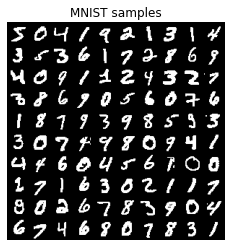

In [ ]:
visualize_q2_data()

In BiGAN, in addition to training a generator $G$ and a discriminator $D$, we train an encoder $E$ that maps from real images $x$ to latent codes $z$. The discriminator now must learn to jointly identify fake $z$, fake $x$, and paired $(x, z)$ that don't belong together. In the original [BiGAN paper](https://arxiv.org/pdf/1605.09782.pdf), they prove that the optimal $E$ learns to invert the generative mapping $G: z \rightarrow x$. Our overall minimax term is now
$$V(D, E, G) = \mathbb{E}_{x \sim p_x}[\mathbb{E}_{z \sim p_E(\cdot | x)}[\log D(x, z)]] + \mathbb{E}_{z \sim p_z}[\mathbb{E}_{x \sim p_G(\cdot | z)}[\log (1 - D(x, z))]]$$

**Architecture**

We will closely follow the MNIST architecture outlined in the original BiGAN paper, Appendix C.1, with one modification: instead of having $z \sim \text{Uniform}[-1, 1]$, we use $z \sim \mathcal N (0, 1)$ with $z \in \mathbb R ^{50}$. 

**Hyperparameters**

We make several modifications to what is listed in the BiGAN paper. We apply $l_2$ weight decay to all weights and decay the step size $\alpha$ linearly to 0 over the course of training. Weights are initialized via the default PyTorch manner. We recommend training for at least 100 epochs -- this part is much less computationally expensive than previous homeworks. 

**Reconstructions**

You should take the first 20 images from the MNIST training set and then display the reconstructions $x_{recon} = G(E(x))$. It's ok if your reconstructions are somewhat lossy; ours are too. We will provide a utility to show these. 

**Testing the representation**

We want to see how good a linear classifier $L$ we can learn such that 
$$y \approx L(E(x))$$
where $y$ is the appropriate label. Fix $E$ and learn a weight matrix $W$ such that your linear classifier is composed of passing $x$ through $E$, then multiplying by $W$, then applying a softmax nonlinearity. Train this via gradient descent with the cross-entropy loss. 

As a baseline, randomly initialize another network $E_{random}$ with the same architecture, fix its weights, and train a linear classifier on top, as done in the previous part.


**You will provide the following deliverables**
1. Plot of the minimax loss term. 
2. 100 samples from the BiGAN
3. A comparison of MNIST images $x$ with their reconstructions $G(E(x))$.
4. Test loss plot for the linear classifier trained on the pretrained encoder, and a randomly initialized encoder. 
5. Final test losses for the two linear classifiers. 

**Feel free to train the networks separately, save the necessary information, and simply use our function to generate the appropriate figures.**


In [ ]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(g_input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024, affine=False),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x).reshape(x.shape[0], 1, 28, 28)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, z_dim, x_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(z_dim + x_dim, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024, affine=False),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )

    def forward(self, z, x):
        return self.model(torch.cat((z, x), dim=1))

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024, affine=False),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, output_dim),
        )

    def forward(self, x):
        return self.model(x.view(x.shape[0], -1))

In [ ]:
class BiGAN:
    def __init__(self, epochs: int = 100):
        self.epochs = epochs
        self.batch_size = 128
        self.latent_dim = 50
        
        self.encoder = Encoder(784, self.latent_dim).to(device) 
        self.discriminator = Discriminator(self.latent_dim, 784).to(device)
        self.generator = Generator(self.latent_dim, 784).to(device)  
        
        self.generator_optim = optim.Adam(list(self.generator.parameters()) + list(self.encoder.parameters()),
                                          lr=2e-4, betas=(0.5, 0.999), weight_decay=2.5e-5)
        
        self.discriminator_optim = optim.Adam(self.discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999),
                                              weight_decay=2.5e-5)
        
    def set_loaders(self, train_loader, test_loader):
        self.train_loader = train_loader
        self.test_loader = test_loader
        
    def set_linear_classifier(self):
        self.lin_clf = nn.Linear(self.latent_dim, 10).to(device)
        self.lin_clf_optim = optim.Adam(self.lin_clf.parameters(), lr=1e-3)
        
    def get_discriminator_loss(self, x):
        batch_size = x.shape[0]
        
        z_fake = torch.normal(torch.zeros(batch_size, self.latent_dim),
                              torch.ones(batch_size, self.latent_dim))
        
        z_fake = z_fake.to(device)
        
        z_real = self.encoder(x).reshape(batch_size, self.latent_dim)
        x_fake = self.generator(z_fake).reshape(batch_size, -1)
        x_real = x.view(batch_size, -1)
        
        a = (self.discriminator(z_real, x_real)).log().mean()
        b = (1 - self.discriminator(z_fake, x_fake)).log().mean()
        
        return -0.5 * (a + b)
        
    def bigan_train(self):
        losses = []
        
        for x, _ in self.train_loader:
            x = x.to(device).float()
            self.discriminator_optim.zero_grad()
            discriminator_loss = self.get_discriminator_loss(x)
            discriminator_loss.backward()
            self.discriminator_optim.step()

            self.generator_optim.zero_grad()
            generator_loss = -self.get_discriminator_loss(x)
            generator_loss.backward()
            self.generator_optim.step()

            losses.append(discriminator_loss.item())
            
        return np.mean(losses)
        
    def fit_bigan(self):
        self.encoder.train()
        self.discriminator.train()
        self.generator.train()
        
        bigan_losses = [self.bigan_train() for epoch in trange(self.epochs, leave=True, desc="BiGAN")]
            
        return bigan_losses
    
    def lin_clf_train(self):
        losses = []
        
        for x, y in self.train_loader:
            x = x.to(device).float()
            y = y.to(device)

            self.lin_clf_optim.zero_grad()
            z = self.encoder(x).detach()
            lin_clf_loss = F.cross_entropy(self.lin_clf(z), y)
            lin_clf_loss.backward()
            self.lin_clf_optim.step()

            losses.append(lin_clf_loss.item())

        return np.mean(losses)
    
    def fit_lin_clf(self):
        lin_clf_losses = []
        
        for epoch in trange(self.epochs // 2, leave=True, desc="Linear classifier"):
            lin_clf_losses.append(self.lin_clf_train())
        
        return lin_clf_losses

## Solution

In [ ]:
def q2(train_data, test_data):
    """
    train_data: A PyTorch dataset that contains (n_train, 28, 28) MNIST digits, normalized to [-1, 1]
                Documentation can be found at torchvision.datasets.MNIST
    test_data: A PyTorch dataset that contains (n_test, 28, 28) MNIST digits, normalized to [-1, 1]
                Documentation can be found at torchvision.datasets.MNIST

    Returns
    - a (# of training iterations,) numpy array of BiGAN minimax losses evaluated every minibatch
    - a (100, 28, 28, 1) numpy array of BiGAN samples that lie in [0, 1]
    - a (40, 28, 28, 1) numpy array of 20 real image / reconstruction pairs
    - a (# of training epochs,) numpy array of supervised cross-entropy losses on the BiGAN encoder evaluated every epoch 
    - a (# of training epochs,) numpy array of supervised cross-entropy losses on a random encoder evaluated every epoch 
    """

    """ YOUR CODE HERE """
    train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=128, shuffle=False)
    
    bigan = BiGAN(epochs=100)
    bigan.set_loaders(train_loader, test_loader)
    bigan.set_linear_classifier()

    random_lin_clf_losses = bigan.fit_lin_clf()

    bigan_losses = bigan.fit_bigan()
    
    with torch.no_grad():
        bigan.generator.eval()
        z = (torch.rand(100, bigan.latent_dim).to(device) - 0.5) * 2
        samples = bigan.generator(z).reshape(-1, 1, 28, 28)
        samples = samples.to('cpu').detach().numpy()
        samples = samples.transpose(0, 2, 3, 1) * 0.5 + 0.5
        
    imgs = train_data.data[:20].reshape(20, 1, 28, 28) / 255.0
    x = torch.FloatTensor(imgs) * 2 - 1
    x = x.to(device)
    
    with torch.no_grad():
        bigan.generator.eval()
        bigan.encoder.eval()
        recons = bigan.generator(bigan.encoder(x))
        recons = recons.reshape(-1, 1, 28, 28).to('cpu').detach().numpy()
        recons = recons * 0.5 + 0.5
        
    imgs_recons = np.concatenate([imgs, recons], axis=0).transpose(0, 2, 3, 1)
    
    bigan.set_linear_classifier()
    lin_clf_losses = bigan.fit_lin_clf()
    
    return bigan_losses, samples, imgs_recons, lin_clf_losses, random_lin_clf_losses

## Results

Linear classifier:   0%|          | 0/50 [00:00<?, ?it/s]

BiGAN:   0%|          | 0/100 [00:00<?, ?it/s]

Linear classifier:   0%|          | 0/50 [00:00<?, ?it/s]

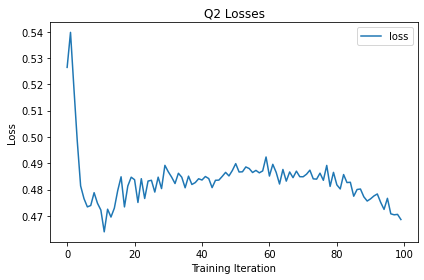

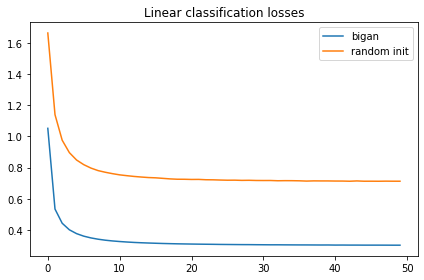

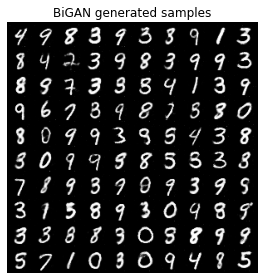

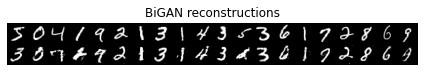

BiGAN final linear classification loss: 0.30294942051998336
Random encoder linear classification loss: 0.7127881116196036


In [ ]:
q2_save_results(q2)

# Bonus 5: CycleGAN
In this question, you'll train a CycleGAN model to learn to translate between two different image domains, without any paired data. Execute the following cell to visualize our two datasets: MNIST and Colored MNIST. 

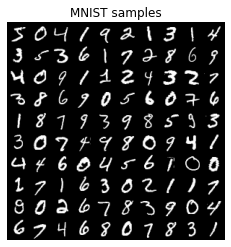

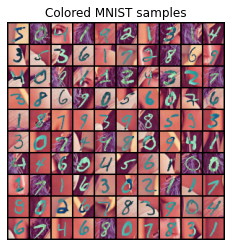

In [ ]:
visualize_cyclegan_datasets()

In [CycleGAN](https://arxiv.org/pdf/1703.10593.pdf), the goal is to learn functions $F$ and $G$ that can transform images from $X \rightarrow Y$ and vice-versa. This is an unconstrained problem, so we additionally enforce the *cycle-consistency* property, where we want 
$$x \approx G(F(x))$$
and  
$$y \approx F(G(x))$$
This loss function encourages $F$ and $G$ to approximately invert each other. In addition to this cycle-consistency loss, we also have a standard GAN loss such that $F(x)$ and $G(y)$ look like real images from the other domain. 

Since this is a bonus question, we won't do much hand-holding. We recommend reading through the original paper to get a sense of what architectures and hyperparameters are useful. Note that our datasets are fairly simple, so you won't need excessively large models. 

**You will report the following deliverables**
1. A set of images showing real MNIST digits, transformations of those images into Colored MNIST digits, and reconstructions back into the greyscale domain. 
2. A set of images showing real Colored MNIST digits, transformations of those images, and reconstructions. 

## Solution

In [ ]:
def b5(mnist_data, cmnist_data):
    """
    mnist_data: An (60000, 1, 28, 28) numpy array of black and white images with values in [0, 1]
    cmnist_data: An (60000, 3, 28, 28) numpy array of colored images with values in [0, 1]

    Returns
    - a (20, 28, 28, 1) numpy array of real MNIST digits, in [0, 1]
    - a (20, 28, 28, 3) numpy array of translated Colored MNIST digits, in [0, 1]
    - a (20, 28, 28, 1) numpy array of reconstructed MNIST digits, in [0, 1]

    - a (20, 28, 28, 3) numpy array of real Colored MNIST digits, in [0, 1]
    - a (20, 28, 28, 1) numpy array of translated MNIST digits, in [0, 1]
    - a (20, 28, 28, 3) numpy array of reconstructed Colored MNIST digits, in [0, 1]
    """
    """ YOUR CODE HERE """

## Results

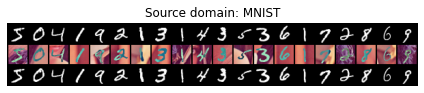

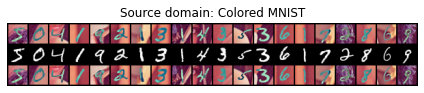

In [ ]:
b5_save_results(b5)